# Proyecto Final del curso de Reconocimiento de Patrones
### Maestría en Electrónica del TEC
### Autor: Pamela Salazar Espinoza

Este cuaderno corresponde al proyecto del curso de reconocimiento de patrones del TEC. El reconocimiento de voz o reconocimiento del habla es una rama de la inteligencia artificial cuya finalidad es posibilitar la comunicación entre humanos y sistemas informáticos. Un sistema de reconocimiento de voz tiene la capacidad de detectar y entender las palabras que un ser humano emite de forma natural. En un esfuerzo por entrenar estos sistemas se han creado diferentes bases de datos en distintos idiomas, con diferentes de acentos por ejemplo la enconteada en: 

https://commonvoice.mozilla.org/es/datasets

El objetivo de este proyecto es entrenar una red neuronal para reconocer algunas palabras dichas utilizando el acento costarricense. Para ello se uso los siguientes audios:

https://www.youtube.com/watch?v=SipemIJjg-E

Para recortar el audio en palabras se uso la herramienta:

https://mp3cut.net/es/

### 1. Limpieza de datos

In [1]:
import pandas as pd
import os


1. Crear una tabla de los archivos con sus respectivas carpetas

In [2]:
contenido = os.listdir('.\dataset\palabras')
archvos_list = []
carpeta_list = []
carpeta_list1 = []
for carpeta in contenido:
    archivos = os.listdir('.\dataset\palabras\\' + carpeta)
    carpeta_list1.append(carpeta)
    for archivo in archivos:
        archvos_list.append(archivo)
        carpeta_list.append(carpeta)

df = pd.DataFrame()
df['Carpeta']  = carpeta_list
df['Archivos'] = archvos_list 
df

,Carpeta,Archivos
0,acompanarlo,acompanarlo1.m4a
1,actividades,audio1 (mp3cut.net) - 2024-03-28T130319.780.m4a
2,adecuada,adecuada1.m4a
3,ambiente,audio1 (mp3cut.net) (76).m4a
4,aqui,aqui1.m4a
...,...,...
351,vecinos,audio1 (mp3cut.net) (93).m4a
352,vecinos,audio1 (mp3cut.net) - 2024-03-28T130351.337.m4a
353,vehiculos,audio1 (mp3cut.net) (89).m4a
354,vida,vida1.m4a


2. Clasificar las muestras.

In [6]:
clases_list = []
clasesID_list = []
for carpeta in df['Carpeta']:
    if carpeta == 'cancer':
        clase = 'cancer'
        id = 0
    elif carpeta == 'tiempo':
        clase = 'tiempo'
        id = 1
    elif carpeta == 'diagnostico':
        clase = 'diagnostico'
        id = 2
    elif carpeta == 'pacientes':
        clase = 'pacientes'
        id = 3
    else:
        clase = 'desconocido'
        id = 4
    clases_list.append(clase)
    clasesID_list.append(id)
df['Clase'] = clases_list
df['Clase ID'] = clasesID_list

df.drop(df[(df['Clase'] == 'desconocido')].index, inplace=True)
df

,Carpeta,Archivos,Clase,Clase ID
20,cancer,cancer1.m4a,cancer,0
21,cancer,cancer10.m4a,cancer,0
22,cancer,cancer11.m4a,cancer,0
23,cancer,cancer12.m4a,cancer,0
24,cancer,cancer13.m4a,cancer,0
...,...,...,...,...
326,tiempo,tiempo5.m4a,tiempo,1
327,tiempo,tiempo6.m4a,tiempo,1
328,tiempo,tiempo7.m4a,tiempo,1
329,tiempo,tiempo8.m4a,tiempo,1


In [4]:
import matplotlib.pyplot as plt

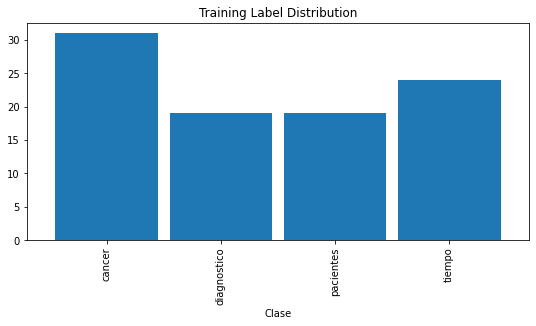

In [7]:
freq = df.groupby(['Clase']).count() 
freq['Archivos'].plot(kind = 'bar', 
             title = 'Training Label Distribution',
             stacked = 'True',          # Muestra las barras apiladas
             alpha = 1,               # nivel de transparencia
             width = 0.9,               # Grosor de las barras para dejar espacio entre ellas
             figsize=(9,4));            # Cambiamos el tamaño de la figura

3. Crear espectogramas
Nota, para crear los espectogramas hay que cambiar el formato del archivo a mp3.

In [14]:
import librosa
import numpy as np
import pickle

In [15]:
def spectogram (audio_file):
    fs = 16000
    y, sr = librosa.load(audio_file, sr = 16000)
    if len(y) < fs:
       y = np.concatenate((y,np.zeros((fs-len(y)),dtype='int')))
    elif len(y) > fs:
        y = y[:fs]
    S = librosa.feature.melspectrogram(y=y, sr=fs, n_mels=40,n_fft =  25*fs//1000, win_length = 25*fs//1000, hop_length = 10*fs//1000, center=True,
        power=2)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

In [18]:
audio_file = 'prueba.mp3'

In [22]:
S_dB = spectogram (audio_file)   

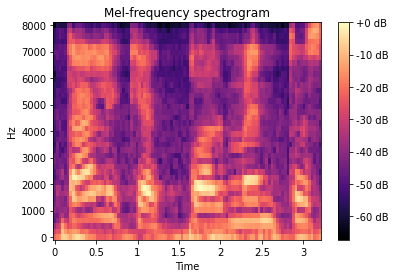

In [23]:
fig, ax = plt.subplots()
img = librosa.display.specshow(S_dB, sr=16000,x_axis='time', y_axis='hz')
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()